# Music Emotion Recognition Model Visualization

This notebook contains comprehensive visualizations for analyzing the performance and behavior of the music emotion recognition model.

In [40]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns


# make plots a bit nicer
plt.style.use('default')

In [41]:
# Load training history & metrics
with open('Music_emotion_history.json') as f:
    history = json.load(f)

with open('Music_emotion_metrics.json') as f:
    metrics = json.load(f)

# Load the exported test arrays
data = np.load('test_data/test_data.npz', allow_pickle=True)
X_test_proc  = data['X_test_proc']
y_test       = data['y_test']
emotion_cols = data['emotion_cols'].tolist()
y_pred_prob  = data['y_pred_prob']
thresholds   = data['thresholds']

print('✓ Data loaded')
print('Test samples:', X_test_proc.shape[0])
print('Emotions:', emotion_cols)

✓ Data loaded
Test samples: 2234
Emotions: ['amazement', 'solemnity', 'tenderness', 'nostalgia', 'calmness', 'power', 'joyful_activation', 'tension', 'sadness']


## Training and Validation Curves
Plots training vs. validation loss (or accuracy) over epochs to diagnose under‑ or over‑fitting and guide hyperparameter tuning.

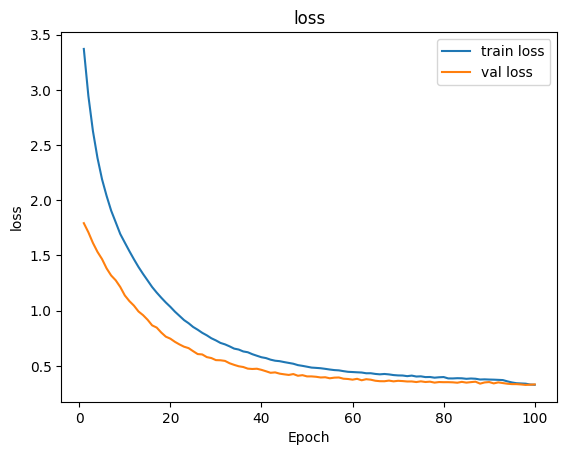

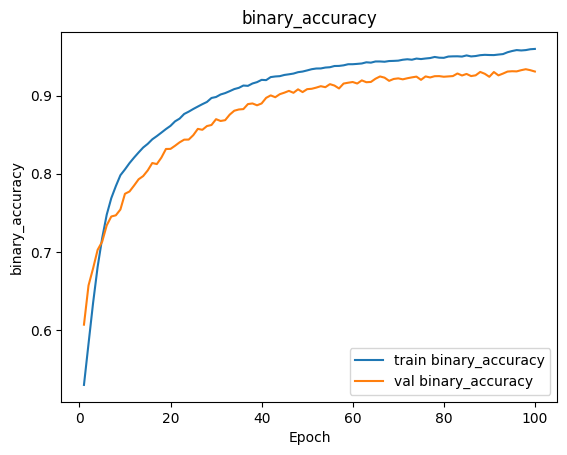

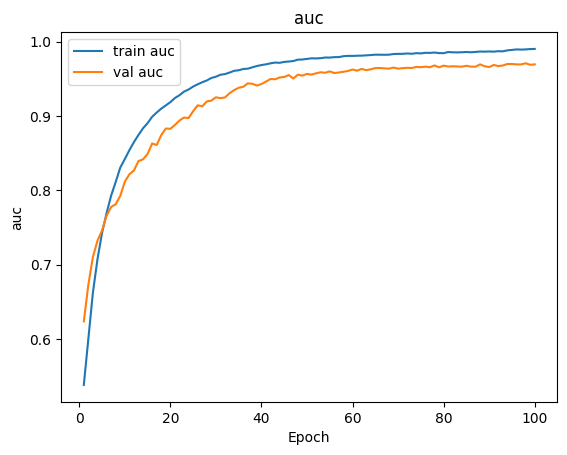

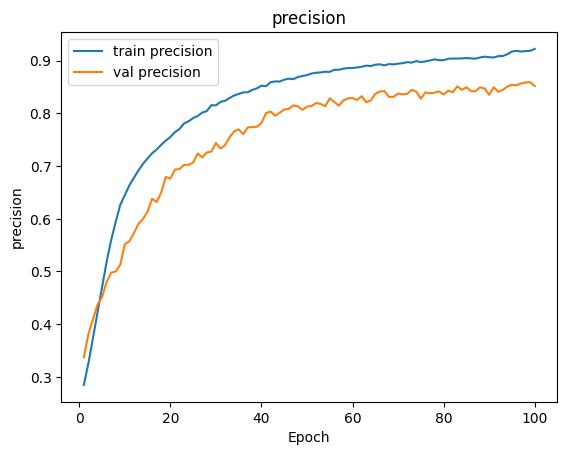

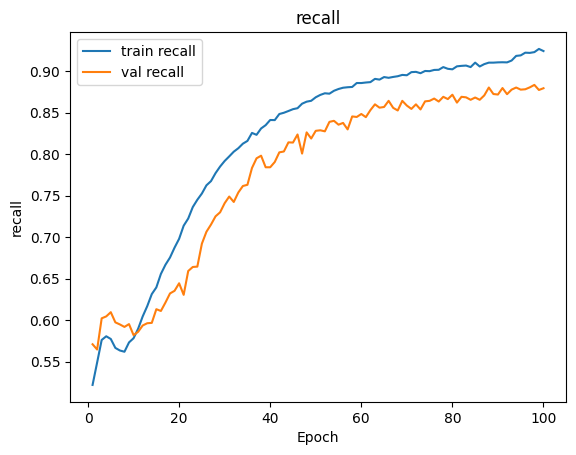

In [42]:
epochs = range(1, len(history['loss'])+1)

def plot_curve(metric):
    plt.figure()
    plt.plot(epochs, history[metric], label=f'train {metric}')
    if f'val_{metric}' in history:
        plt.plot(epochs, history[f'val_{metric}'], label=f'val {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(metric)
    plt.legend()
    plt.show()

for m in ['loss', 'binary_accuracy', 'auc', 'precision', 'recall']:
    plot_curve(m)

## Overall Test Metrics
Displays aggregate measures (e.g., micro‑F1, macro‑F1, hamming loss) to give a concise summary of model performance across all labels.

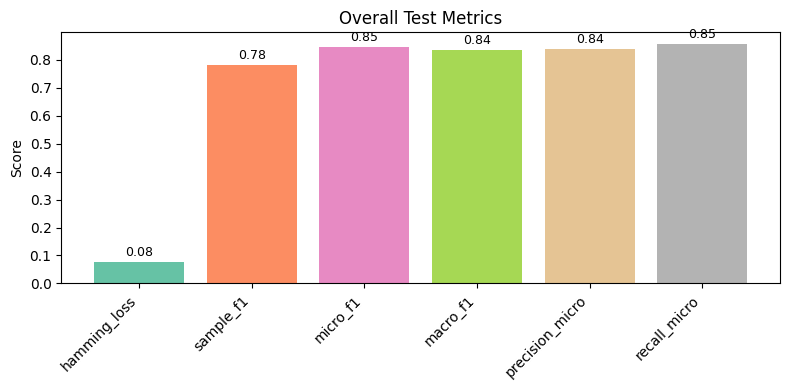

In [43]:
keys = ['hamming_loss','sample_f1','micro_f1','macro_f1',
        'precision_micro','recall_micro']
vals = [metrics[k] for k in keys]

cmap = plt.cm.Set2
colors = cmap(np.linspace(0, 1, len(keys)))

plt.figure(figsize=(8,4))
bars = plt.bar(keys, vals, color=colors)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Overall Test Metrics')

for bar, v in zip(bars, vals):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.01,
             f'{v:.2f}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Per‑emotion Metrics Bar
Bar chart of individual F1, precision, and recall scores for each emotion reveals label‑specific strengths and weaknesses.

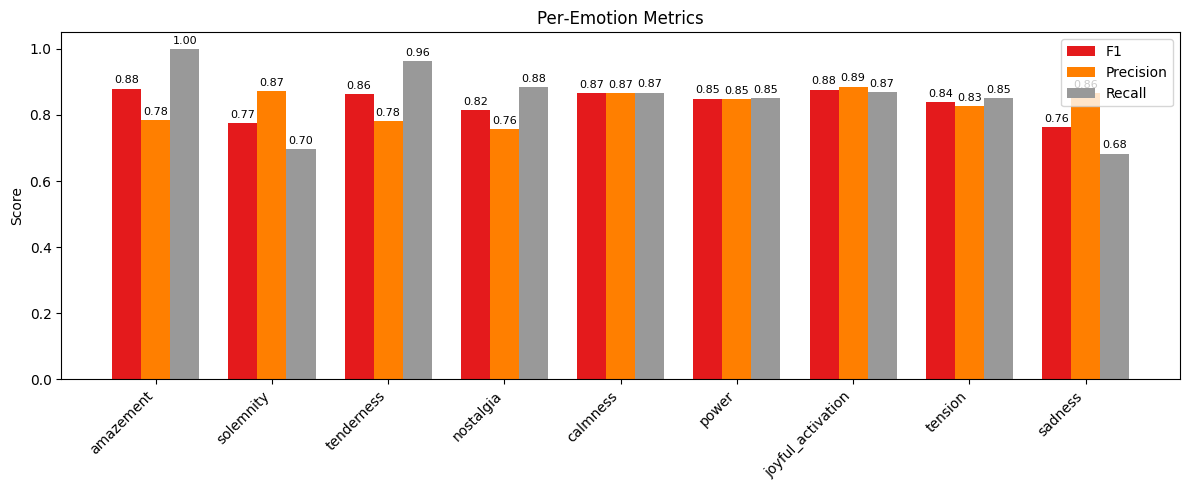

In [44]:
f1s = [metrics[f'{e}_f1']        for e in emotion_cols]
prs = [metrics[f'{e}_precision'] for e in emotion_cols]
rcs = [metrics[f'{e}_recall']    for e in emotion_cols]

x = np.arange(len(emotion_cols))
w = 0.25

palette = plt.cm.Set1(np.linspace(0, 1, 3))

plt.figure(figsize=(12,5))
bars1 = plt.bar(x-w, f1s, w, label='F1',        color=palette[0])
bars2 = plt.bar(x,   prs, w, label='Precision', color=palette[1])
bars3 = plt.bar(x+w, rcs, w, label='Recall',    color=palette[2])

plt.xticks(x, emotion_cols, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Per‑Emotion Metrics')
plt.legend()

for bars in (bars1, bars2, bars3):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2,
                 height + 0.01,
                 f'{height:.2f}',
                 ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## Confusion Matrices
Matrix showing true vs. predicted counts for each emotion helps pinpoint common misclassification patterns.

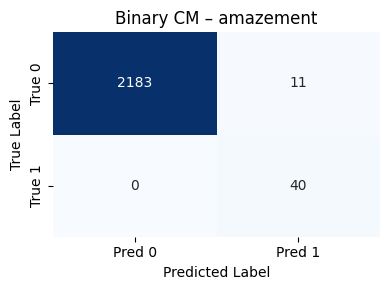

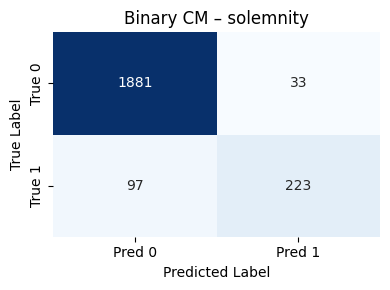

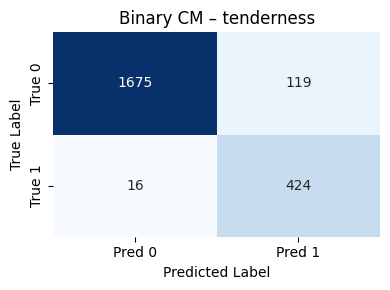

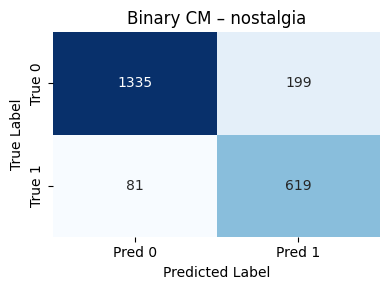

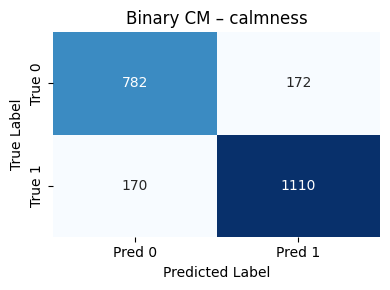

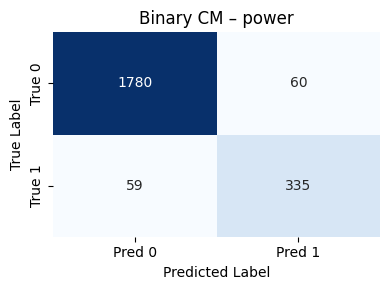

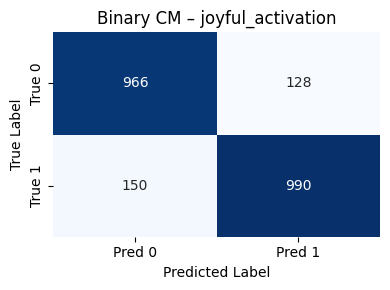

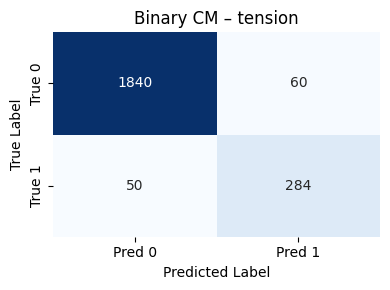

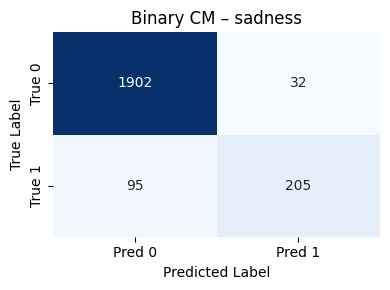


Calculating and plotting multi-label confusion (co-occurrence) matrix...


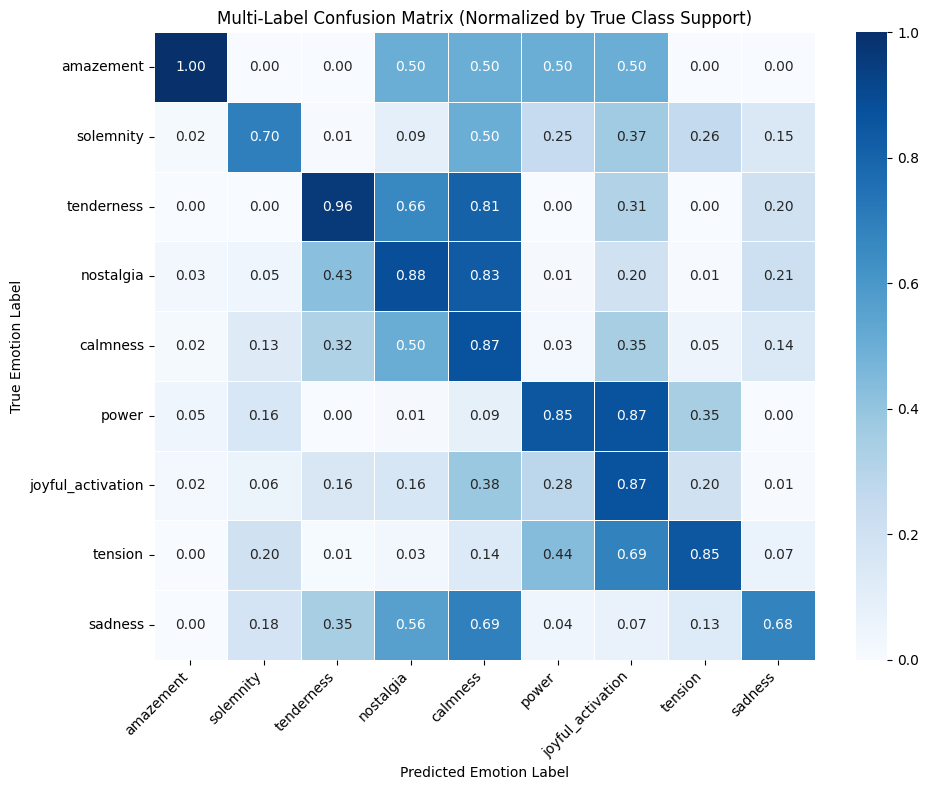

In [45]:
num_emotions = len(emotion_cols)
individual_cms = [] # Store individual CMs if needed later

for i, emo in enumerate(emotion_cols):
    # Assuming y_test contains the true binary labels (0 or 1)
    # If y_test contains scores, it needs binarization first based on ground truth criteria.
    y_true_emo = y_test[:, i]
    y_pred_emo = (y_pred_prob[:, i] >= thresholds[i]).astype(int)

    # Calculate the standard 2x2 confusion matrix for this emotion
    # TN, FP, FN, TP = confusion_matrix(y_true_emo, y_pred_emo).ravel()
    # Or just get the matrix:
    cm_binary = confusion_matrix(y_true_emo, y_pred_emo)
    individual_cms.append(cm_binary) # Store it

    # --- Plotting the individual 2x2 CM (Optional - keep if you want these) ---
    plt.figure(figsize=(4, 3))
    # Use seaborn for consistency, or keep your original plt.imshow
    sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'],
                cbar=False) # No colorbar needed for simple 2x2 usually
    plt.title(f'Binary CM – {emo}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    # --- End optional individual plotting ---

print("\nCalculating and plotting multi-label confusion (co-occurrence) matrix...")

# 1. Get binary predictions for ALL emotions first
y_pred_bin = (y_pred_prob >= thresholds).astype(int)
# Ensure y_test is also binary [num_samples, num_emotions]
# If y_test is not binary, you need to define how to binarize it first!
# Example: y_true_bin = (y_test > 0.5).astype(int) # Adjust threshold as needed
y_true_bin = y_test.astype(int) # Assuming y_test is already binary {0, 1}

# 2. Calculate the multi-label confusion matrix (normalized by true support)
num_emotions = len(emotion_cols)
multi_label_cm = np.zeros((num_emotions, num_emotions))

# Calculate support (number of true instances for each emotion)
support = np.sum(y_true_bin, axis=0)

for i in range(num_emotions): # Iterate over TRUE emotions (rows)
    if support[i] == 0:
        # Avoid division by zero if an emotion never occurs in the test set
        continue

    # Find samples where emotion 'i' is TRUE
    true_mask_i = (y_true_bin[:, i] == 1)

    # Get the predictions for THESE samples across ALL emotions
    predictions_for_true_i = y_pred_bin[true_mask_i, :]

    # Calculate how often each emotion 'j' was predicted for these samples
    # Summing along axis 0 gives the count for each predicted emotion (columns)
    prediction_counts = np.sum(predictions_for_true_i, axis=0)

    # Normalize by the number of times emotion 'i' was true (support)
    multi_label_cm[i, :] = prediction_counts / support[i]

# 3. Plot the multi-label confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8)) # Adjust size as needed
sns.heatmap(multi_label_cm,
            annot=True,           # Show values in cells
            fmt=".2f",            # Format values to 2 decimal places (proportions)
            cmap="Blues",         # Colormap
            xticklabels=emotion_cols,
            yticklabels=emotion_cols,
            linewidths=.5,        # Add lines between cells
            cbar=True)            # Show color bar

plt.title('Multi-Label Confusion Matrix (Normalized by True Class Support)')
plt.xlabel('Predicted Emotion Label')
plt.ylabel('True Emotion Label')
plt.xticks(rotation=45, ha='right') # Rotate labels if they overlap
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout
plt.show()

## ROC Curves per Emotion
Receiver‑Operating Characteristic curves plot True Positive Rate vs. False Positive Rate across thresholds to assess separability for each label.

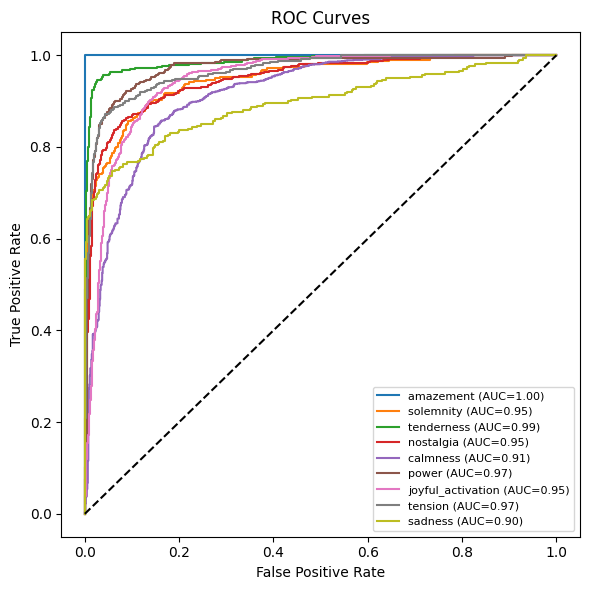

In [46]:
plt.figure(figsize=(6,6))
for i, emo in enumerate(emotion_cols):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{emo} (AUC={roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

## Precision–Recall Curves
Plots precision vs. recall across thresholds, especially informative under class imbalance, highlighting the trade‑off between false positives and false negatives.

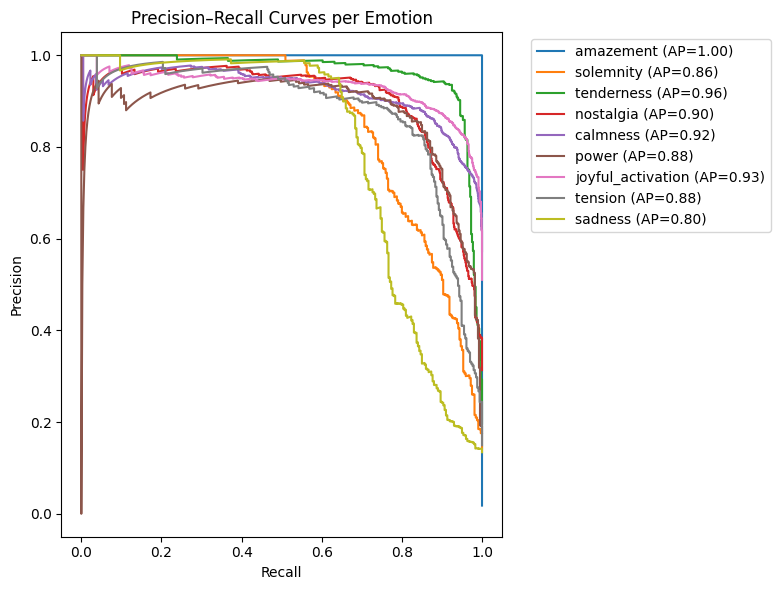

In [47]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8,6))
for i, emotion in enumerate(emotion_cols):
    y_true = y_test[:, i]
    y_score = y_pred_prob[:, i]
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    plt.plot(rec, prec, label=f"{emotion} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves per Emotion")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## Calibration Plots
Reliability diagrams compare predicted probabilities to observed frequencies to detect over‑ or under‑confidence in model’s soft outputs.


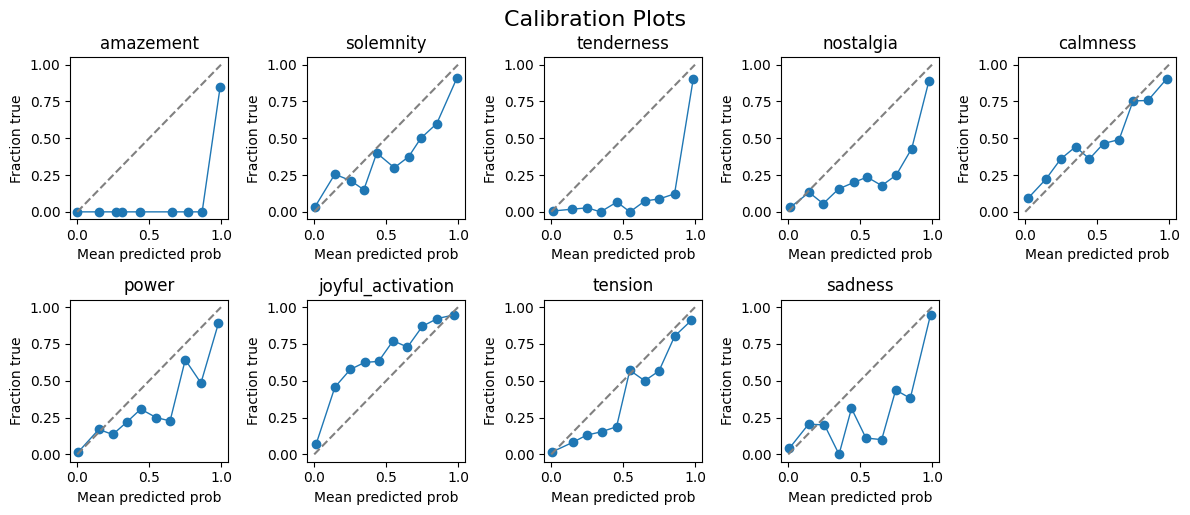

In [48]:
from sklearn.calibration import calibration_curve

n_bins = 10
plt.figure(figsize=(12,5))

for i, emotion in enumerate(emotion_cols):
    plt.subplot(2, int(np.ceil(len(emotion_cols)/2)), i+1)
    prob_true, prob_pred = calibration_curve(y_test[:,i], y_pred_prob[:,i], n_bins=n_bins)
    plt.plot(prob_pred, prob_true, marker='o', linewidth=1)
    plt.plot([0,1],[0,1], linestyle='--', color='gray')
    plt.title(emotion)
    plt.xlabel("Mean predicted prob")
    plt.ylabel("Fraction true")
    plt.tight_layout()

plt.suptitle("Calibration Plots", y=1.02, fontsize=16)
plt.show()

## Threshold‑Sensitivity Analysis
Graph of a global metric (e.g. micro‑F1) vs. decision threshold visualizes how performance varies, aiding selection of an operating point.

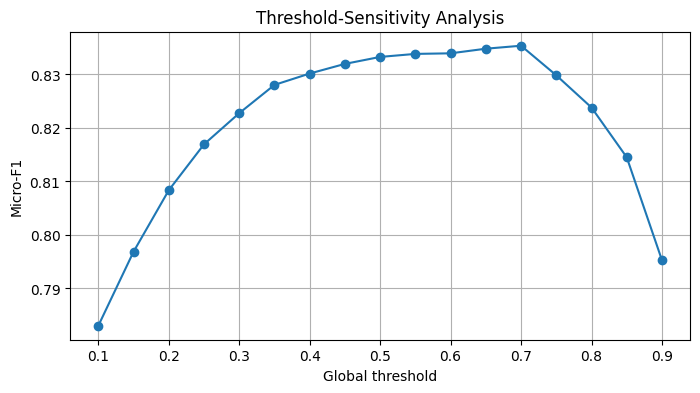

In [49]:
from sklearn.metrics import f1_score

ths = np.linspace(0.1, 0.9, 17)
micro_f1 = []

for t in ths:
    y_pred = (y_pred_prob >= t).astype(int)
    micro_f1.append(f1_score(y_test, y_pred, average='micro'))

plt.figure(figsize=(8,4))
plt.plot(ths, micro_f1, marker='o')
plt.xlabel("Global threshold")
plt.ylabel("Micro‑F1")
plt.title("Threshold‑Sensitivity Analysis")
plt.grid(True)
plt.show()

## t‑SNE Embedding
Nonlinear dimensionality reduction that maps high‑dim features into 2D/3D to reveal cluster structure and separability of emotion classes.

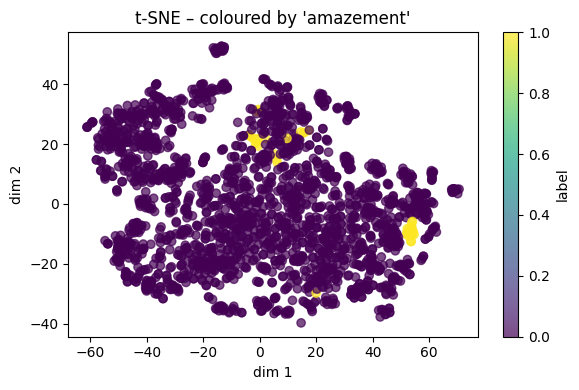

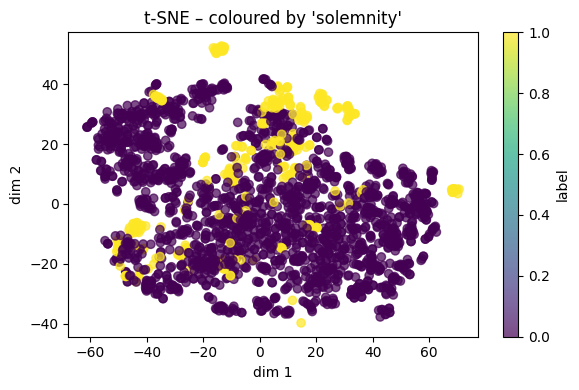

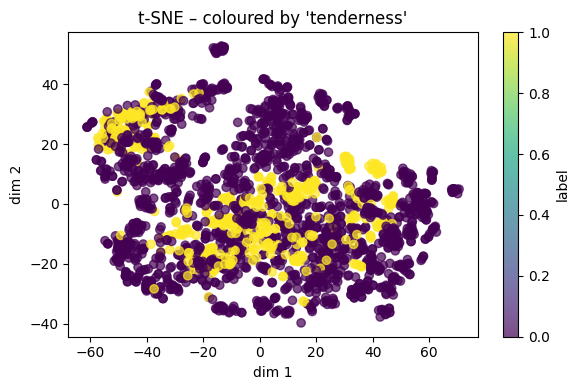

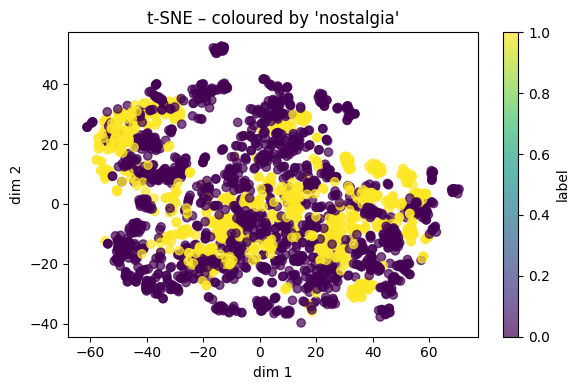

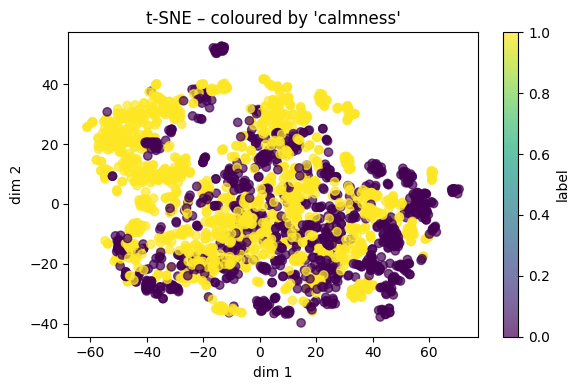

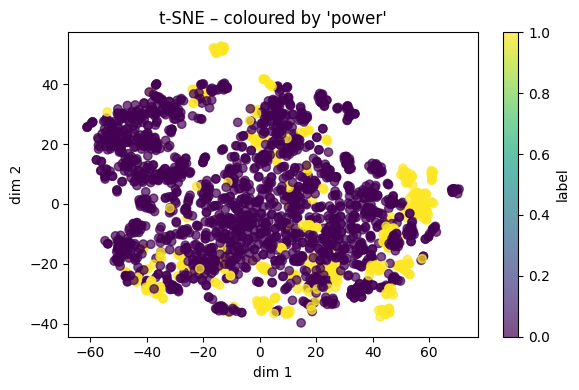

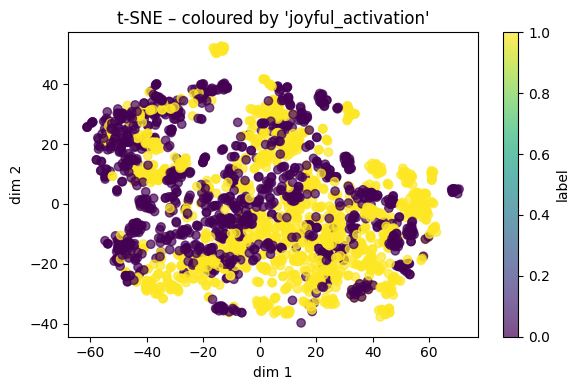

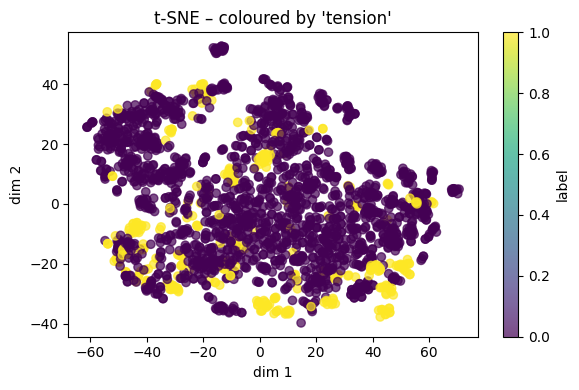

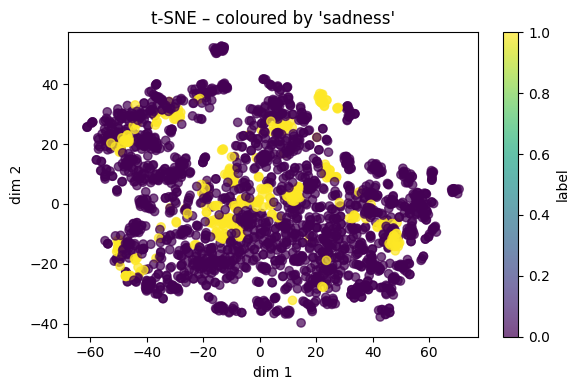

In [50]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# flatten features
X_flat = X_test_proc.reshape(X_test_proc.shape[0], -1)

# pca → 50 components
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_flat)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# plot for each emotion
for i, emo in enumerate(emotion_cols):
    plt.figure(figsize=(6,4))
    plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_test[:,i], alpha=0.7)
    plt.title(f"t‑SNE – coloured by '{emo}'")
    plt.xlabel('dim 1'); plt.ylabel('dim 2')
    plt.colorbar(label='label')
    plt.tight_layout()
    plt.show()

## Alternative Embeddings (PCA / UMAP / 3D t‑SNE)
PCA offers linear projections, UMAP preserves both local and global topology, and 3D t‑SNE extends neighborhood visualizations—together giving complementary views of feature space.

C:\Users\rockw\Downloads\Kodlama\Music Emotion Recognition\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\rockw\Downloads\Kodlama\Music Emotion Recognition\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


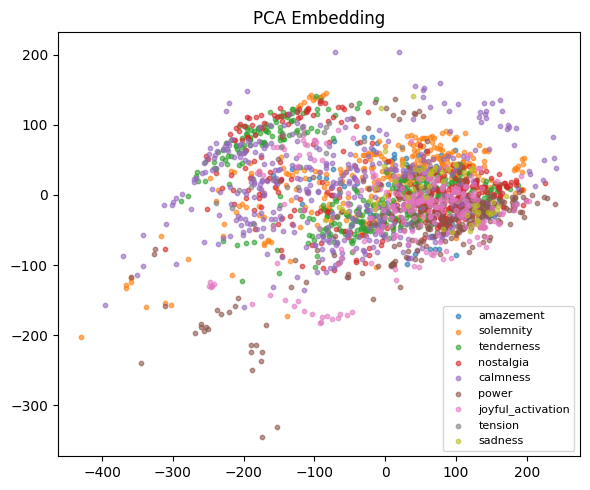

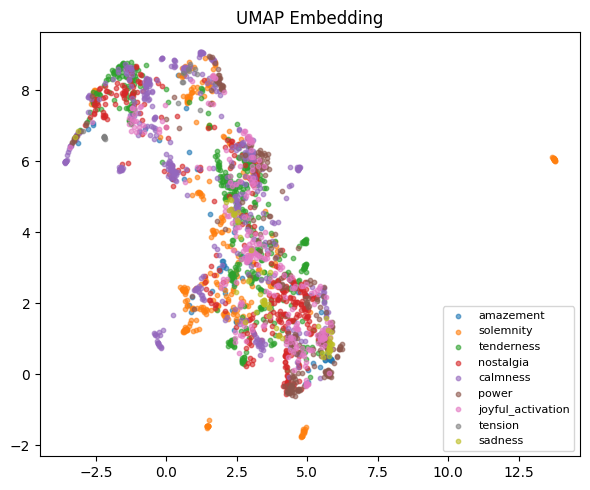

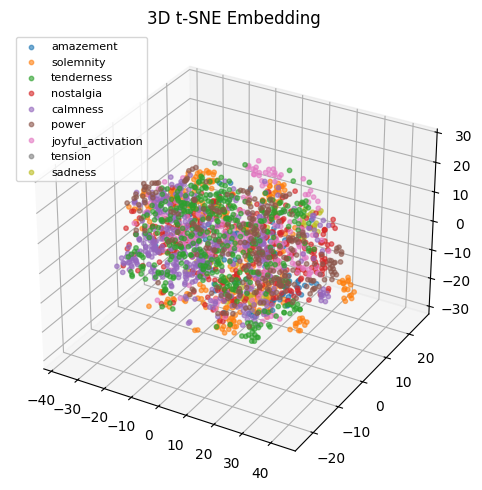

In [51]:
# Flatten features (e.g. channel‑wise mean)
X_flat = X_test_proc.reshape(X_test_proc.shape[0], -1)

# PCA 2D
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2).fit_transform(X_flat)

# UMAP 2D
import umap
umap2 = umap.UMAP(n_components=2, random_state=42).fit_transform(X_flat)

# 3D t‑SNE
from sklearn.manifold import TSNE
tsne3 = TSNE(n_components=3, random_state=42, init='pca').fit_transform(X_flat)

def scatter2(data, title):
    plt.figure(figsize=(6,5))
    for lab in np.unique(y_test.argmax(1)):
        idx = y_test.argmax(1)==lab
        plt.scatter(data[idx,0], data[idx,1], s=10, label=emotion_cols[lab], alpha=0.6)
    plt.legend(loc='best', fontsize=8)
    plt.title(title)
    plt.tight_layout()

scatter2(pca2, "PCA Embedding")
scatter2(umap2, "UMAP Embedding")

# 3D t-SNE
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
for lab in np.unique(y_test.argmax(1)):
    idx = y_test.argmax(1)==lab
    ax.scatter(tsne3[idx,0], tsne3[idx,1], tsne3[idx,2],
               s=10, alpha=0.6, label=emotion_cols[lab])
ax.set_title("3D t‑SNE Embedding")
ax.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

## Error‑Analysis Dashboards
A coordinated set of visuals—cohort diagnostics, slice‑and‑dice tables, model interpretability widgets—that surface systematic failures.

### 1. Confusion Heatmap Between Emotions
Aggregates pairwise confusions across labels into a heatmap to identify emotion pairs most frequently mixed up.

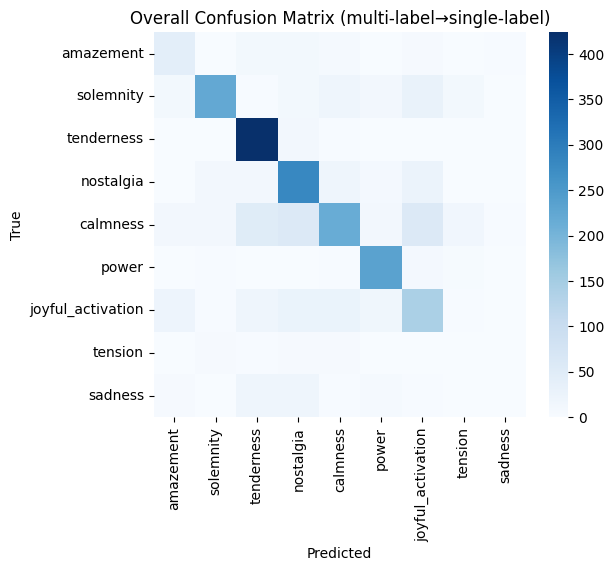

In [52]:
# pairwise confusion: how often emotion A is predicted when B is true
cm = confusion_matrix(y_test.argmax(1), (y_pred_prob>=thresholds).argmax(1))
plt.figure(figsize=(6,5))
sns.heatmap(cm, xticklabels=emotion_cols, yticklabels=emotion_cols, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Overall Confusion Matrix (multi‑label→single‑label)")
plt.show()

### 2. Hard Examples
Displays “challenging” spectrograms or audio snippets the model misclassified, making abstract errors tangible for qualitative inspection.

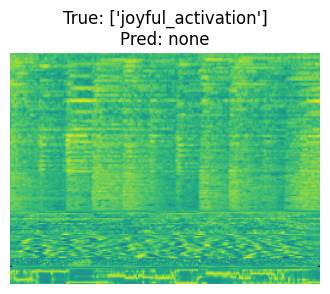

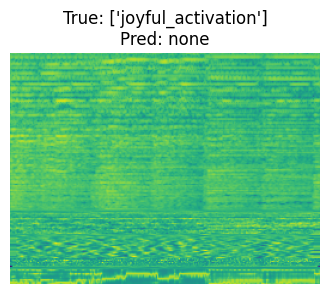

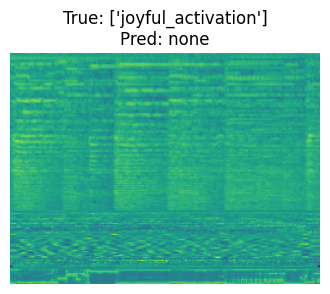

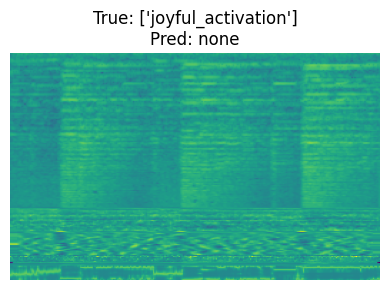

In [53]:
hard_idx = np.where((y_test.sum(1)>0) & ((y_pred_prob>=thresholds).sum(1)==0))[0]
# show first 4 “missed” positives
for i in hard_idx[:4]:
    plt.figure(figsize=(4,3))
    plt.imshow(X_test_proc[i,:,:,0], aspect='auto')
    plt.title(f"True: {[e for j,e in enumerate(emotion_cols) if y_test[i,j]==1]}\nPred: none")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Model Visualization

In [24]:
import tensorflow as tf
import pydot

model = tf.keras.models.load_model("music_emotion_model.keras")

tf.keras.utils.plot_model(model,

           to_file='keras_model_plot.png',

           show_shapes=True,

           show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
